In [1]:
# torch
import torchvision
import torchvision.transforms.functional as F
import torch
import random
import matplotlib.pyplot as plt

# paths
import os
import sys

# set paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# my imports
from config import config
from voc_subset import VOCSubset
from utils import voc_utils

# the lifesaver
%load_ext autoreload
%autoreload 2


### Dataset Sub-Section

This notebook will take a subset of the PASCAL VOC dataset containing images with a selected class. Images may include more than one class, but the interesting class is the one specified in `selected_class`.

In [2]:
selected_class_name = "cat"  

# toggle between loading and saving
SAVE = False

# path to store the dataset (pytorch datasets)
path_to_voc = config.dataset_path

# path to store \ load the selected indices
indices_file = os.path.join("indices", f"VOC_{selected_class_name}_selected_indices.pth")


This  will download the PASCAL VOC dataset to the `path_to_voc_` directory.

**!! Set download=true if you don't have the data !!**

In [3]:
# load the PASCAL VOC dataset (VOC 2012), 
dataset = torchvision.datasets.VOCDetection(
    root=path_to_voc,
    year='2012',
    image_set='trainval', # get both
    download=False
)

In [4]:
if SAVE:
    selected_indices = []
    # scan the dataset and save
    for idx, (_, target) in enumerate(dataset):
        # get all objects
        annotations = target['annotation']['object']
        # get all the object names (for each object)
        class_ids = [obj['name'] for obj in annotations]
        # check if the selected class is in the annotations
        if selected_class_name in class_ids:
            selected_indices.append(idx)

    # Save indices to a file for faster access later
    torch.save(selected_indices, indices_file)
    print(f"Saved {len(selected_indices)} indices of images containing class '{selected_class_name}'")

else:
    # load from file
    selected_indices = torch.load(indices_file)
    print(f"Loaded {len(selected_indices)} indices of images containing class '{selected_class_name}'")

Loaded 1084 indices of images containing class 'cat'


Check that we selected OK - all the images should include the selected class.

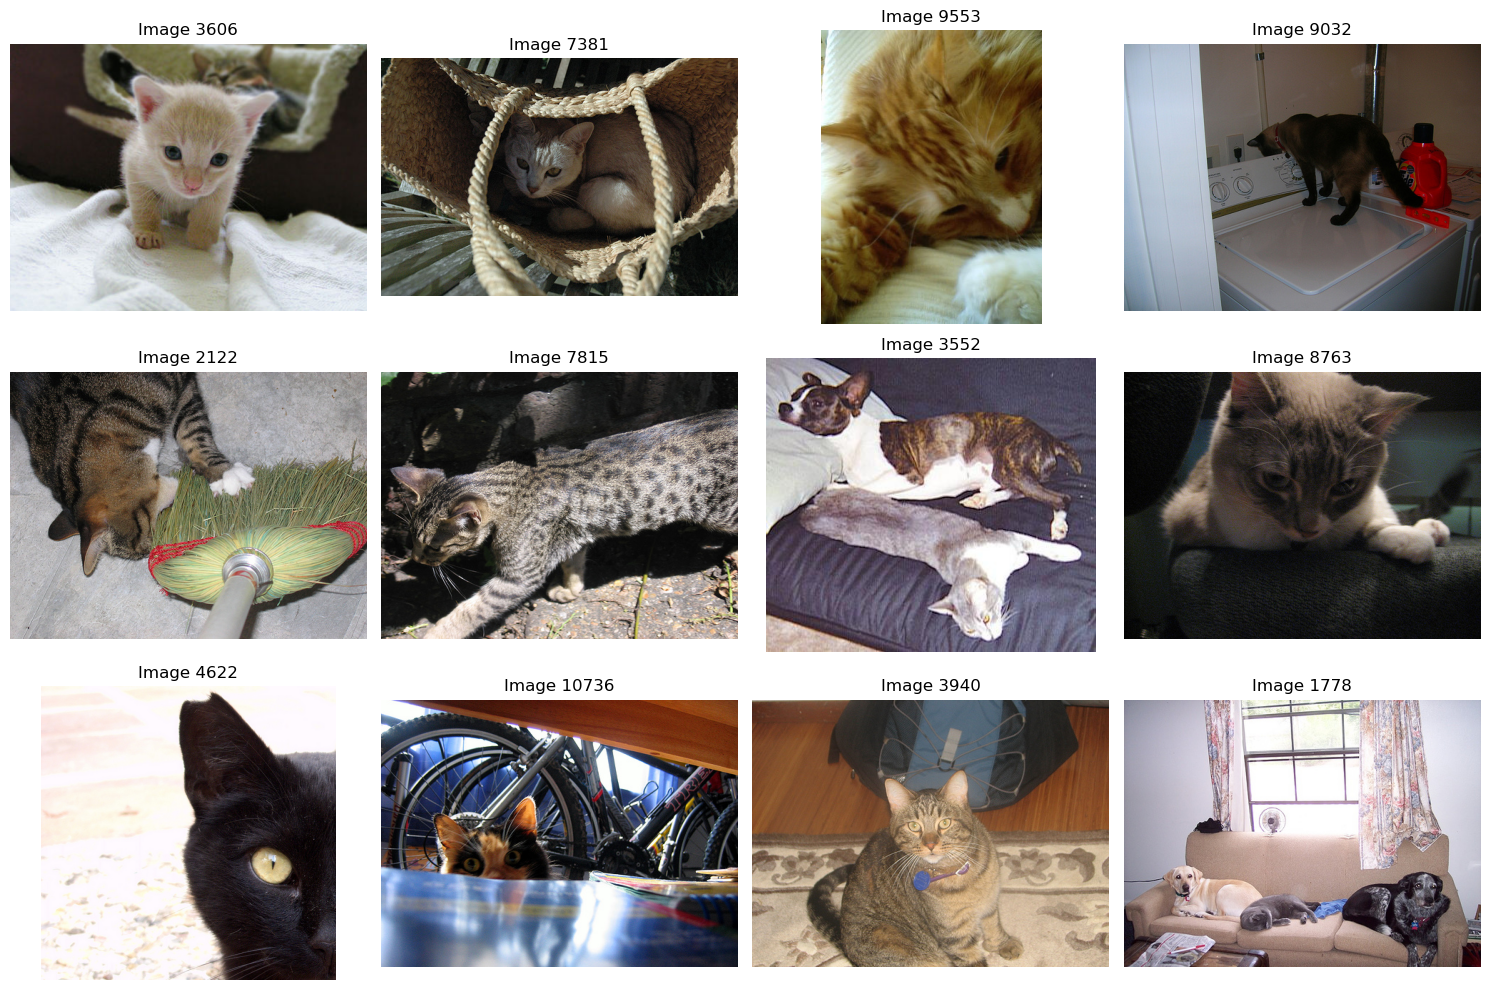

In [5]:
random_indices = random.sample(selected_indices, 12)

# Set up matplotlib figure
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

# Display the images
for i, idx in enumerate(random_indices):
    image, target = dataset[idx]
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Image {idx}")

# Show the plot
plt.tight_layout()
plt.show()

And also test by building a dataloader with single class. We also want to check that the image selector creates the correct bounding box around a **single** object only.

In [6]:
# build subset dataset
subsetDataset = VOCSubset(
    indices_list = selected_indices, 
    selected_class = selected_class_name,
    single_instance = True,
    transform = torchvision.transforms.ToTensor()
)

assert (len(subsetDataset) == len(selected_indices))
print(f'Subset dataset loaded sucessfully, len = {len(subsetDataset)}')

Subset dataset loaded sucessfully, len = 1084


Assert that the dataset includes only the chosen class and one instance per image:

In [9]:
for i in range(len(subsetDataset)):
    image, target = subsetDataset[i]
    # # check that the annotations contain only one object
    # assert len(target['labels']) == 1, f"More than one object found in image {i}"
    # check that the annotations all contain the chosen class
    label_names = voc_utils.voc_idx_to_class(target['labels'])
    assert selected_class_name in label_names, f"{selected_class_name} does not appear in label {i}"

print("All objects contain the class 'cat'.")

RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

Verify the subset dataset and the bbox:

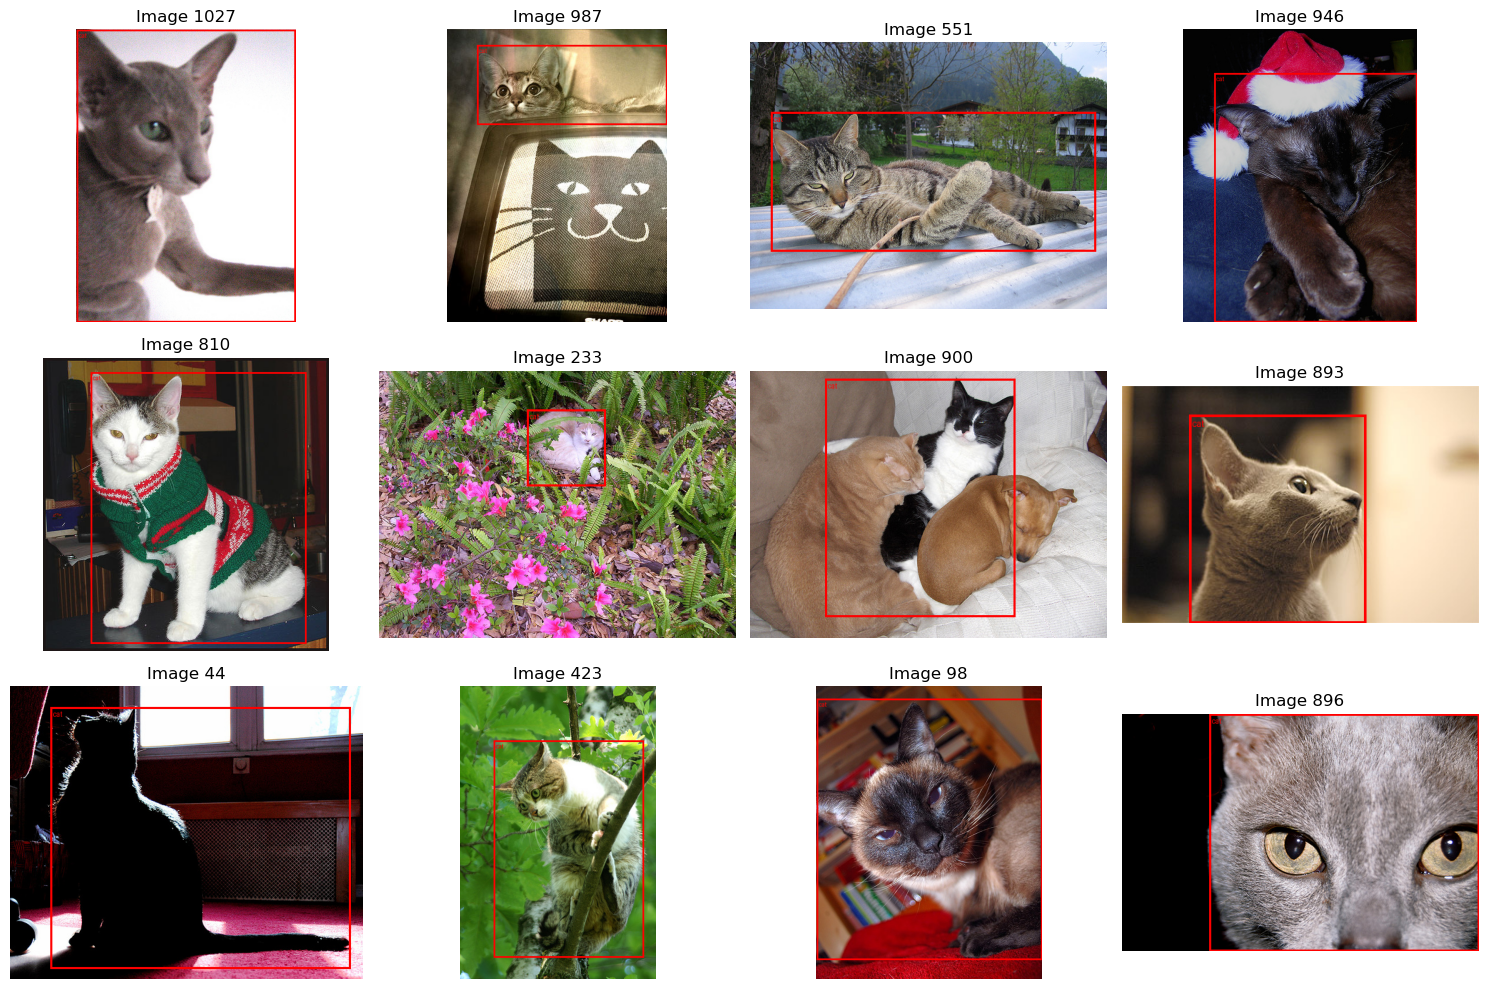

In [ ]:
random_indices = random.sample(range(len(subsetDataset)), 12)

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

# Display the images
for i, idx in enumerate(random_indices):
    # get the data and target
    image, target = subsetDataset[idx]
    # parse the target to torch notation
    torchTarget =  voc_utils.parse_target_voc_torch(target)
    # use my shiny custom function
    image_with_boxes_PIL = voc_utils.voc_img_bbox_plot(image, torchTarget, [selected_class_name])
    
    # Plot the image with bounding boxes
    axes[i].imshow(image_with_boxes_PIL)
    axes[i].axis('off') 
    axes[i].set_title(f"Image {idx}")

# Show the plot
plt.tight_layout()
plt.show()